In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

In [3]:
chrom = "22"
model = "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True"
min_count_per_consequence = 100

variants = f"../../results/positions/{chrom}/llr/{model}.subsample_10000000.annot.parquet"
#variants = f"../../results/positions/{chrom}/llr/{model}.conserved_pos_full_22.annot.parquet"

V = pl.read_parquet(variants)
V = V.with_columns(
    pl.col("consequence").str.replace("_variant", "")
)

# optional: replace with model without flipping
V = V.with_columns(
    score=pl.read_parquet("../../results/preds/results/ism_subset/multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/False.parquet")["score"]
)

V

chrom,pos,ref,alt,score,consequence
str,i64,str,str,f32,str
"""22""",10510068,"""A""","""G""",-2.857422,"""intergenic"""
"""22""",10510076,"""T""","""G""",-4.382812,"""intergenic"""
"""22""",10510080,"""A""","""T""",-4.503906,"""intergenic"""
"""22""",10510084,"""T""","""C""",1.0390625,"""intergenic"""
"""22""",10510087,"""T""","""G""",-1.240234,"""intergenic"""
"""22""",10510093,"""C""","""T""",-0.216919,"""intergenic"""
"""22""",10510098,"""T""","""C""",-4.558594,"""intergenic"""
"""22""",10510100,"""C""","""A""",-3.8125,"""intergenic"""
"""22""",10510100,"""C""","""G""",-3.941406,"""intergenic"""


In [4]:
c_counts = V["consequence"].value_counts().sort("count", descending=True)
c_counts

consequence,count
str,u32
"""intron""",5275697
"""intergenic""",3446002
"""non_coding_tra…",443413
"""3_prime_UTR""",198938
"""upstream_gene""",183453
"""downstream_gen…",170413
"""missense""",140041
"""5_prime_UTR""",46155
"""synonymous""",42172


In [5]:
c_quantile = V.filter(
    pl.col("consequence").is_in(c_counts.filter(pl.col("count") >= min_count_per_consequence)["consequence"])
).group_by("consequence").agg(pl.quantile("score", 0.01)).sort("score")
c_quantile

consequence,score
str,f32
"""splice_accepto…",-13.203125
"""stop_gained""",-13.125
"""splice_donor""",-13.109375
"""splice_donor_5…",-12.921875
"""missense""",-12.679688
"""start_lost""",-12.460938
"""stop_lost""",-12.460938
"""splice_donor_r…",-11.03125
"""mature_miRNA""",-10.515625


In [6]:
c_plot = c_quantile["consequence"]
c_plot

consequence
str
"""splice_accepto…"
"""stop_gained"""
"""splice_donor"""
"""splice_donor_5…"
"""missense"""
"""start_lost"""
"""stop_lost"""
"""splice_donor_r…"
"""mature_miRNA"""


In [7]:
#c_plot = c_plot_backup.clone()

In [8]:
#c_plot_backup = c_plot.clone()

In [9]:
#c_plot = [
#    "stop_gained",
#    "missense",
#    "synonymous",
#]

In [10]:
score_col = "GPN-MSA score"
df = V.filter(pl.col("consequence").is_in(c_plot)).to_pandas()
df["g"] = df.consequence
df[score_col] = df.score
df['consequence'] = pd.Categorical(df['consequence'], categories=c_plot, ordered=True)
df = df.sort_values("consequence")
df

,chrom,pos,ref,alt,score,consequence,g,GPN-MSA score
4965860,22,31106165,T,G,-5.156250,splice_acceptor,splice_acceptor,-5.156250
7892591,22,42560184,A,C,-9.421875,splice_acceptor,splice_acceptor,-9.421875
3015484,22,23462679,C,G,-0.204346,splice_acceptor,splice_acceptor,-0.204346
6733965,22,38025867,A,G,-2.248047,splice_acceptor,splice_acceptor,-2.248047
3588808,22,25709897,G,T,-9.460938,splice_acceptor,splice_acceptor,-9.460938
...,...,...,...,...,...,...,...,...
3680017,22,26067410,A,G,-1.184570,intergenic,intergenic,-1.184570
3680016,22,26067408,C,A,-6.226562,intergenic,intergenic,-6.226562
3680015,22,26067400,C,A,-4.457031,intergenic,intergenic,-4.457031
3680033,22,26067454,G,T,-3.611328,intergenic,intergenic,-3.611328


In [11]:
q = 1 / 10_000
x_left, x_right = df[score_col].quantile(q), df[score_col].quantile(1-q)
x_left, x_right

(-12.921875, 5.8515625)

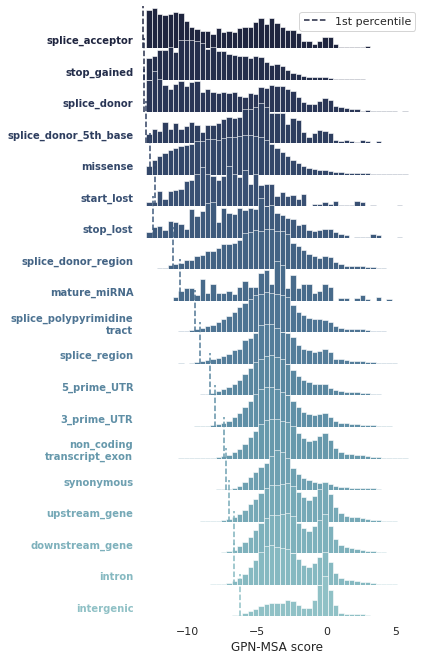

In [12]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(len(c_plot), rot=-.25, light=.7, reverse=True)
g = sns.FacetGrid(
    df, row="g", hue="g",
    aspect=10,#15,
    #height=.5,  # doesn't work
    #height=1, # this works
    height=0.5,
    palette=pal,
    sharey=False,
)

g.map(
    sns.histplot,
    score_col,
    bins=np.linspace(x_left, x_right, 50),
    alpha=1,
    fill=True,
    stat="density",
)

def label(x, color, label):
    #n = c_counts.filter(consequence=label)[0, "count"]
    #label = label.replace("stop_gained", "stop-gain")
    #label = label.replace("_", " ")
    #label = f"{label} (n={format_number(n)})"
    label = label.replace("non_coding_transcript_exon", "non_coding\ntranscript_exon")
    label = label.replace("splice_polypyrimidine_tract", "splice_polypyrimidine\ntract")
    ax = plt.gca()
    ax.text(
        0, .2, label, fontweight="bold", color=color,
        ha="right",
        va="center", transform=ax.transAxes
    )
g.map(label, score_col)

# start: quantile
#"""
def add_quantile(x, color, label):
    ax = plt.gca()
    artist = ax.axvline(x.quantile(0.01), ls='--', color=color)
    
g.map(add_quantile, score_col)

import matplotlib
artist = [c for c in g.axes[0,0].get_children() if type(c)==matplotlib.lines.Line2D][0]
legend = g.axes[0,0].legend([artist], ["1st percentile"], loc="upper right")
legend.get_frame().set_facecolor('white')
#"""
# end: quantile

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True);



#plt.axvline(-1.6)

#plt.savefig("../../results/plots/ism.svg", bbox_inches="tight")
#plt.savefig("../../results/plots/ism_noshuffle.svg", bbox_inches="tight")

#plt.savefig("../../results/plots/ism_fully_conserved_pos_subset.svg", bbox_inches="tight")

In [13]:
#0.625, 0.125, 0.125, 0.125